## 1. Imports & CSV-Reading

In [1]:
import os
os.chdir("/home/reffert/DeepAR_InfluenzaForecast")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.dataset.util import to_pandas
from gluonts.dataset import common
from gluonts.evaluation import make_evaluation_predictions
from PythonFiles.Configuration import Configuration
from PythonFiles.PlottingFunctions import plot_forecast_entry
from datetime import datetime

config = Configuration()
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FurtherResearch/meningococcal.csv", sep=',')
df.head()

,Unnamed: 0,year,date,week,age_group,location,value
0,0,2001,2001-01-07,1,00+,LK Ahrweiler,0.0
1,1,2001,2001-01-14,2,00+,LK Ahrweiler,0.0
2,2,2001,2001-01-21,3,00+,LK Ahrweiler,0.0
3,3,2001,2001-01-28,4,00+,LK Ahrweiler,0.0
4,4,2001,2001-02-04,5,00+,LK Ahrweiler,0.0


## 2. Data Processing

In [2]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
# create a pd.Index() object as a reference for a correctly spaced index
correctly_spaced_index = pd.date_range(start=config.train_start_time,
                                       end=config.test_end_time,
                                       freq=config.parameters["freq"])

# create a df out of this index
correctly_spaced_location_df = pd.DataFrame(index=correctly_spaced_index)
correctly_spaced_df = pd.DataFrame()
location_list = df.loc[:, 'location'].unique()
# iterate through locations and join them on the correctly spaced df
# lastly concat them to a uniform df that contains all locations
for location in location_list:
    temporary_df = correctly_spaced_location_df.join(df.loc[df.location == location])
    temporary_df['location'] = temporary_df['location'].fillna(location)
    temporary_df['age_group'] = temporary_df['age_group'].fillna("00+")
    correctly_spaced_df = pd.concat([correctly_spaced_df, temporary_df])

## 3. Data Splitting with ListDataset

In [3]:
gluonts_df = correctly_spaced_df.copy()
# set the training time to any early date, so we can guarantee to include all data
config.train_start_time = datetime(1998,1,1,0,0,0)
# select the first date
start = gluonts_df.loc[(gluonts_df.index>=config.train_start_time)].index[0]
print(start)
# A ListDataset requires 3 fields [start, target and freq]
# The ListDataset doesn't work with the dates within our dataset, instead it uses the defined start date
# and frequency as well as the amount of values present in the given df[target]
# -> Therefore the correctly spaced df is necessary
training_data = common.ListDataset(
            [{"start": start, "target": gluonts_df.loc[(gluonts_df.index >= config.train_start_time) & 
                                               (gluonts_df.index <= config.train_end_time) & 
                                               (gluonts_df.location == location), config.target]}
             for location in gluonts_df.loc[:, 'location'].unique()], freq=config.parameters["freq"])
# The test data set contains all training observations and the additional test set observations
test_data = common.ListDataset(
            [{"start": start, "target": gluonts_df.loc[(gluonts_df.index <= config.test_end_time) & 
                                               (gluonts_df.index >= config.train_start_time) & 
                                               (gluonts_df.location == location), config.target]}
             for location in gluonts_df.loc[: , 'location'].unique()], freq=config.parameters["freq"])

1999-01-03 00:00:00


## 4. Estimator training and Prediction

In [4]:
estimator = DeepAREstimator(freq=config.parameters["freq"],
                            context_length=208,
                            prediction_length=104,
                            num_layers=config.parameters["num_layers"],
                            num_cells=config.parameters["num_cells"],
                            cell_type=config.parameters["cell_type"],
                            trainer=Trainer(epochs=config.parameters["epochs"],
                                            learning_rate=config.parameters["learning_rate"]),
                            distr_output=config.parameters["distr_output"],
                           )

predictor = estimator.train(training_data=training_data)
# create iterator objects for [num_samples] prediction paths
forecast_it, ts_it = make_evaluation_predictions(dataset=test_data,  
                                                 predictor=predictor,  
                                                 num_samples=100,  
                                                 )
# The last two lines take most of the time
forecasts = list(forecast_it)
tss = list(ts_it)

100%|██████████| 50/50 [00:21<00:00,  2.29it/s, epoch=8/8, avg_epoch_loss=0.119]


## 5. Plotting of selected time series

SK München


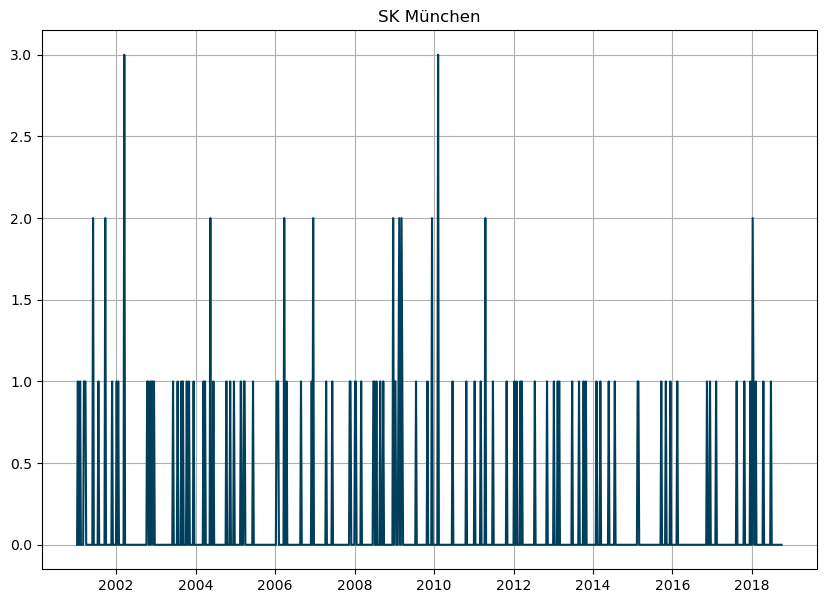

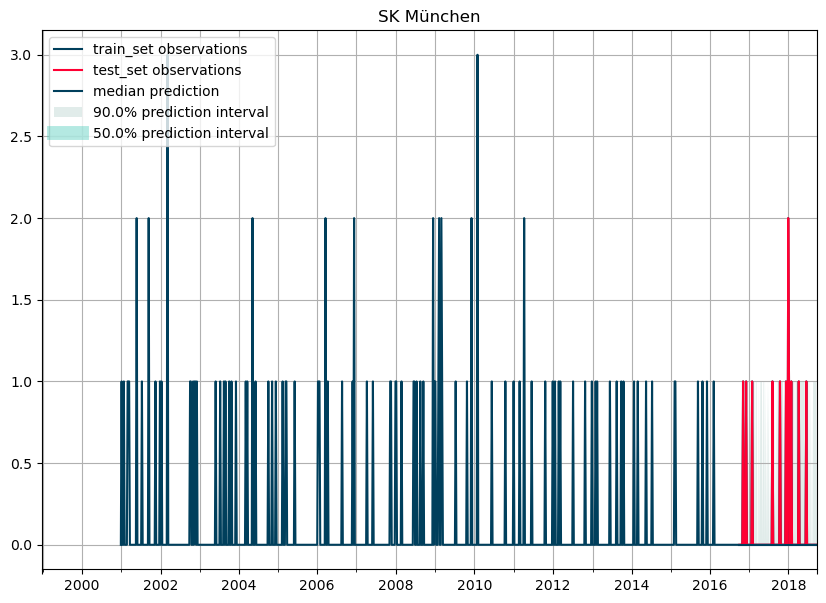

LK Bad Dürkheim


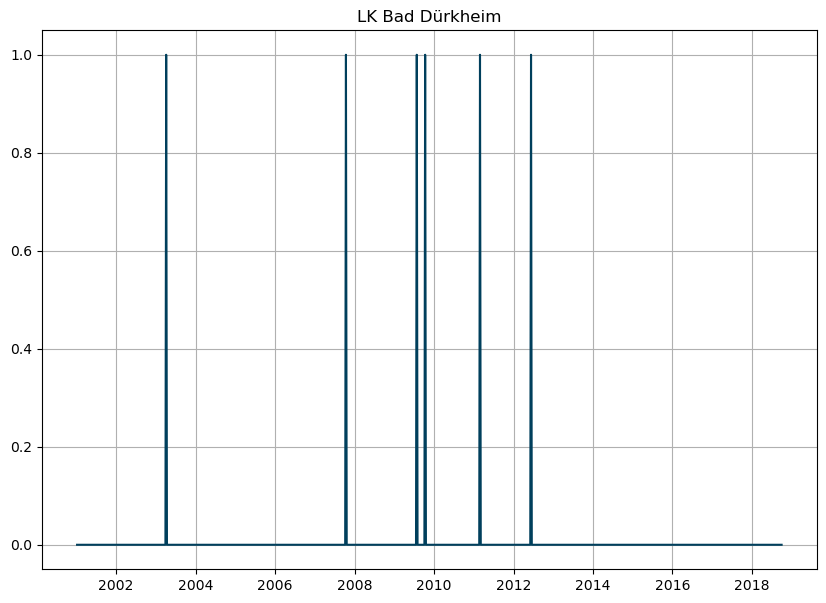

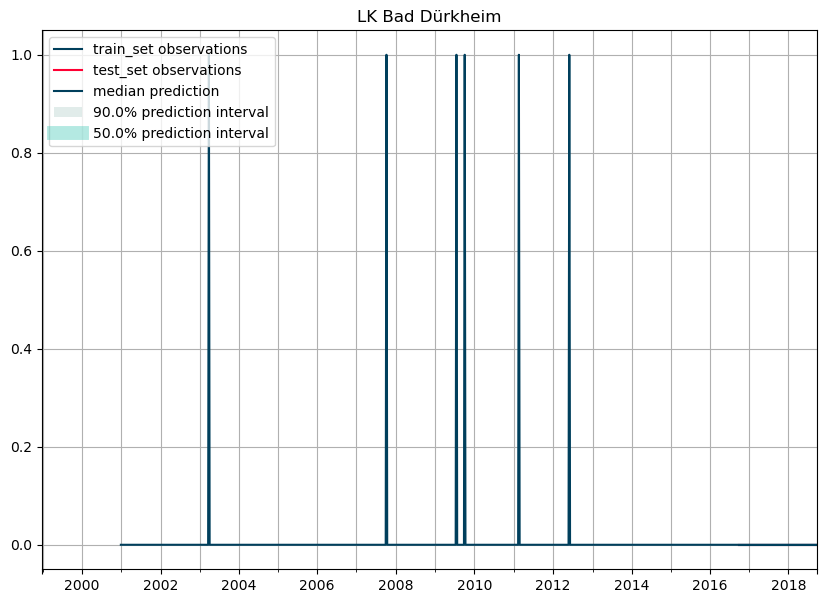

In [11]:
def plot_prob_forecasts(config, ts_entry, forecast_entry, test_data, title=""):
    plot_length = 104
    prediction_intervals = (50.0, 90.0)
    legend = ["train_set observations", "test_set observations", "median prediction"] \
             + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    to_pandas(test_data).to_timestamp().plot(color=config.colors[0])
    ts_entry[-plot_length:].plot(ax=ax, color=config.colors[1])  # plot the time series
    plot_forecast_entry(config, forecast_entry, show_mean=False,ax=plt, prediction_intervals=(50.0, 90.0), meancolor=config.colors[1], mediancolor=config.colors[0], fillcolor=config.colors[4])
    plt.grid(which="both")
    plt.title(title)
    plt.legend(legend, loc="upper left")
    plt.show()

locations = [location for location in gluonts_df.loc[:, 'location'].unique()]
selected_regions = ["SK München", "LK Bad Dürkheim"]
for k in [locations.index(location) for location in selected_regions]:
    ts_entry = tss[k]
    forecast_entry = forecasts[k]
    print(locations[k])
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{locations[k]}')
    # Plot the true values once seperately
    plt.plot((gluonts_df.loc[(gluonts_df['location'] == str(locations[k])) & 
                     (gluonts_df.index <= config.test_end_time) & 
                     (gluonts_df.index >= config.train_start_time)].index),
             gluonts_df.loc[(gluonts_df['location'] == str(locations[k])) &
                    (gluonts_df.index <= config.test_end_time) &
                    (gluonts_df.index >= config.train_start_time),'value'], c=config.colors[0])
    plt.grid(which="both")
    plt.show()
    plot_prob_forecasts(config, ts_entry, forecast_entry, test_data[k], title=f'{locations[k]}')

## Plotting of overall cases

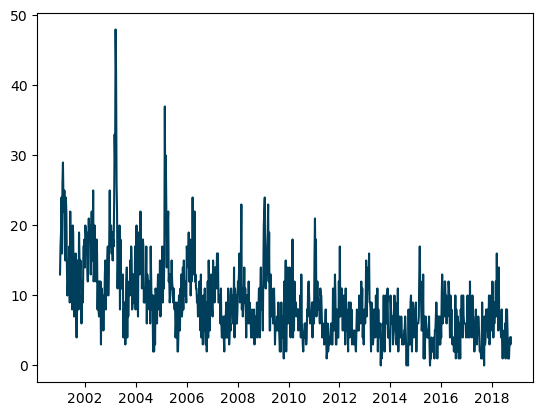

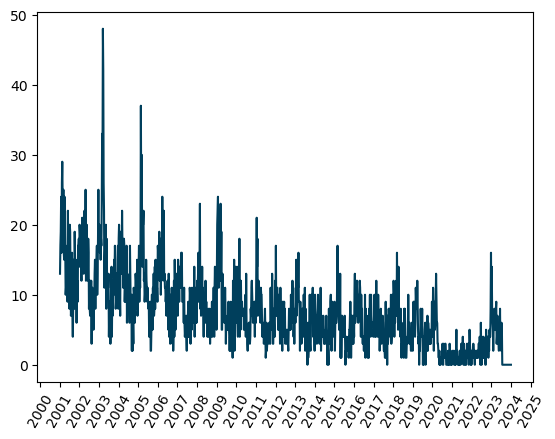

In [6]:
import matplotlib.dates as mdates
sum_df = pd.DataFrame()
sum_df.index = df.index.unique()
for date in df.index.unique():
    sum_df.loc[sum_df.index == date,'value'] = df.loc[df.index == date]['value'].sum()
plt.plot((sum_df.loc[(sum_df.index <= config.test_end_time) & 
                 (sum_df.index >= config.train_start_time)].index),
         sum_df.loc[(sum_df.index <= config.test_end_time) &
                (sum_df.index >= config.train_start_time),'value'], config.colors[0])
plt.show()
plt.plot(sum_df.index, sum_df.value, config.colors[0])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=60) 
plt.show()

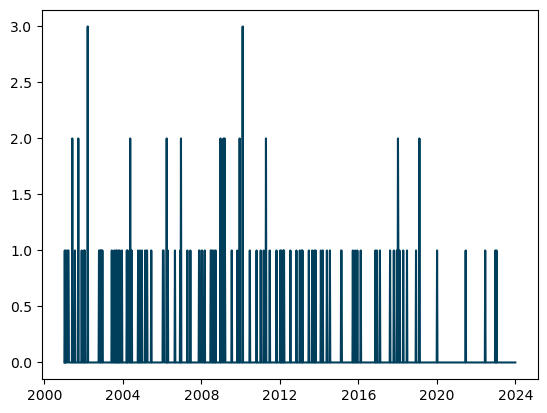

In [3]:
location = "SK München"
plt.plot((df.loc[df.location == location,:].index), df.loc[df.location == location, "value"], config.colors[0])
plt.show()

            Unnamed: 0  year  week age_group             location  value
date                                                                    
2001-01-07           0  2001     1       00+         LK Ahrweiler    0.0
2001-01-14           1  2001     2       00+         LK Ahrweiler    0.0
2001-01-21           2  2001     3       00+         LK Ahrweiler    0.0
2001-01-28           3  2001     4       00+         LK Ahrweiler    0.0
2001-02-04           4  2001     5       00+         LK Ahrweiler    0.0
...                ...   ...   ...       ...                  ...    ...
2023-12-03       21367  2023    48       00+  StädteRegion Aachen    0.0
2023-12-10       21368  2023    49       00+  StädteRegion Aachen    0.0
2023-12-17       21369  2023    50       00+  StädteRegion Aachen    0.0
2023-12-24       21370  2023    51       00+  StädteRegion Aachen    0.0
2023-12-31       21371  2023    52       00+  StädteRegion Aachen    0.0

[493200 rows x 6 columns]
            value
date  

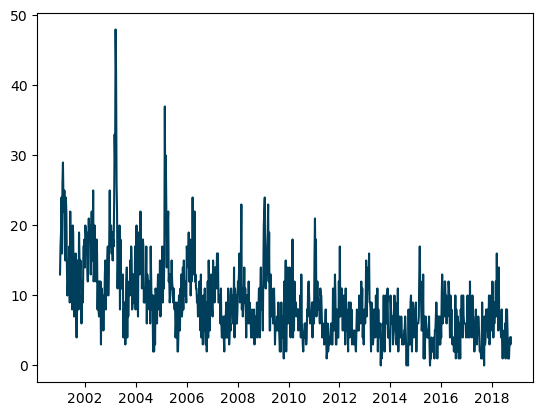

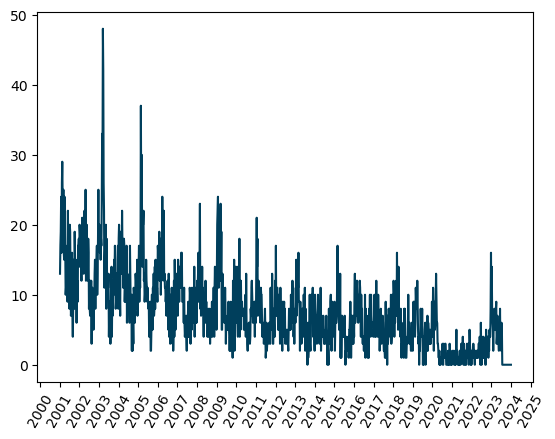

In [2]:
import matplotlib.dates as mdates

print(df)
sum_df = pd.DataFrame()
sum_df.index = df.index.unique()
for date in df.index.unique():
    sum_df.loc[sum_df.index == date,'value'] = df.loc[df.index == date]['value'].sum()
print(sum_df)
plt.plot((sum_df.loc[(sum_df.index <= config.test_end_time) & 
                 (sum_df.index >= config.train_start_time)].index),
         sum_df.loc[(sum_df.index <= config.test_end_time) &
                (sum_df.index >= config.train_start_time),'value'], config.colors[0])
plt.show()
plt.plot(sum_df.index, sum_df.value, config.colors[0])
# Setting up the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set locator to every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=60) 
plt.show()